In [1]:
%matplotlib inline
import pandas as pd
import json
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
from pylab import plot, show, text
import datetime
import matplotlib.dates as mdates
import pylab

In [2]:
logins = pd.read_json('logins.json')

### Data Exploration

In [3]:
logins.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [15]:
logins.set_index(pd.to_datetime(logins.login_time, unit='m'), inplace=True)

In [17]:
freqs = logins.groupby(pd.Grouper(freq='15Min')).agg(['count'])['login_time']

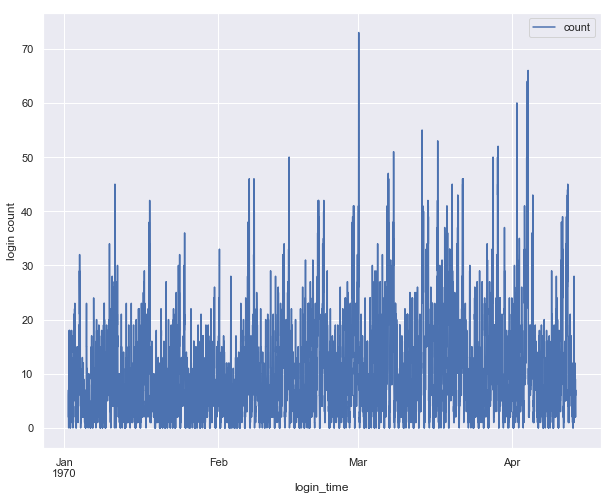

In [14]:
freqs.plot(figsize=(10, 8))
plt.ylabel('login count')
plt.show()

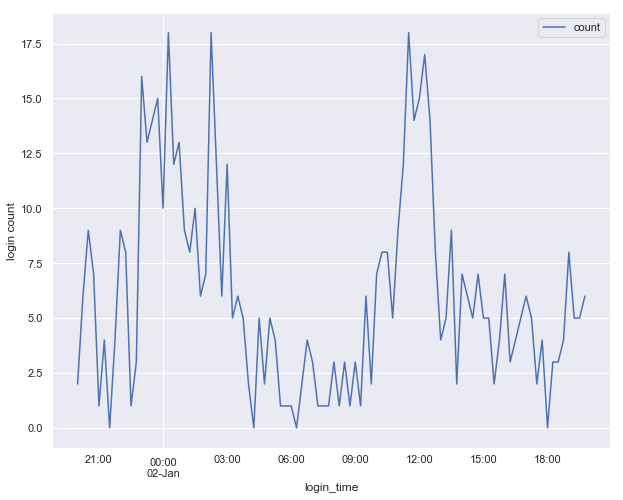

In [24]:
freqs.iloc[:96].plot(figsize=(10, 8))
plt.ylabel('login count')
plt.show()

- Login peak hours is from 22:00 to 5:00
- Max peak hours is from 4:00 to 6:00 AM with 50 to 73 logins
- Based on moving average window of past 100 logins, there is an increase on the login from 10 to 15 logins from Jan to Apr 1970
- Highest number of logins in March 1970


### Part 2. Experiment Design 
Two neighboring cities have complementary traffic patterns. One is active during day and other during night. To encourage driver partners to be available in both cities two-way tolls are re-imbursed.

- A good metric to evaluate the effectiveness of reimbursement policy is to take the difference in means of number of available driver partners (or alternatively customer waiting times) with and without the policy for each city.

- A practical experiment to verify this metric would be as follows:

- Get multiple Random samples of drivers in each city. $R_g$ for Gotham and $R_m$ for Metropolis.
- Divide all of the two groups further evenly as treatment and control. Reimburse toll costs for treatments.
- There will be four different means we calculate:
- In Gotham:
    - Take a difference of means of drivers from Gotham for treatment vs control group.
    - Take a difference of means of drivers from Metropolis for treatment vs control group.
- Similarly in Metropolis:
    - Difference of means of drivers from Gotham for treatment vs control group.
    - Difference of means of drivers from Metropolis for treatment vs control group.
- Repeat the above for different times of day.

- The null hypothesis is that there is no difference in means for treatment vs control across towns and times. The alternative hypothesis is that there is a difference in means.

- A significance level is picked, say 5% and the hypothesis is checked against the drawn samples for reaching a conclusion.

### Part 3. Predictive Modeling - User Retention
A sample dataset for a cohort of users for trips taken is given. The goal of the model is predict whether a user will take at least one trip in a 30 day interval and understand the most important predictors for that.

In [25]:
# Load the data
with open('ultimate_data_challenge.json') as f:
    e_json = json.load(f)
engagement = pd.DataFrame(e_json)
engagement.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


### Data Exploration

In [26]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [27]:
engagement.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


### Data Processing

In [28]:
# Impute missing values
eng_clean = engagement
eng_clean['avg_rating_by_driver'] = eng_clean.avg_rating_by_driver.fillna(eng_clean.avg_rating_by_driver.mean())
eng_clean['avg_rating_of_driver'] = eng_clean.avg_rating_of_driver.fillna(eng_clean.avg_rating_of_driver.mean())
eng_clean['phone'] = eng_clean.phone.fillna('UNKNOWN')
eng_clean['signup_date'] = pd.to_datetime(eng_clean.signup_date)
eng_clean['last_trip_date'] = pd.to_datetime(eng_clean.last_trip_date)

eng_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [30]:
# Function to build response variable
def get_y(row):
    signup = row['signup_date']
    start = signup + pd.DateOffset(months = 5)
    end = signup + pd.DateOffset(months = 6)
    last = row['last_trip_date']
    if last > start and last <= end:
        return True
    else:
        return False

y = eng_clean.apply(get_y, axis=1)

print('Number of users that are active in 6th month: {0}'.format(np.sum(y)))


Number of users that are active in 6th month: 11711


In [31]:
# Feature Engineering
X_start = eng_clean[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 
                     'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']]

X_cat = pd.get_dummies(eng_clean[['city', 'phone', 'ultimate_black_user']])

X = pd.concat([X_start, X_cat], axis=1)
X.head()


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,ultimate_black_user,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_UNKNOWN,phone_iPhone
0,3.67,5.0,4.7,1.10,15.4,4,46.2,True,0,1,0,0,0,1
1,8.26,5.0,5.0,1.00,0.0,0,50.0,False,1,0,0,1,0,0
2,0.77,5.0,4.3,1.00,0.0,3,100.0,False,1,0,0,0,0,1
3,2.36,4.9,4.6,1.14,20.0,9,80.0,True,0,1,0,0,0,1
4,3.13,4.9,4.4,1.19,11.8,14,82.4,False,0,0,1,1,0,0


#### Building Model and Hyper-parameter Tuning

In [32]:
from sklearn.model_selection import train_test_split

# Split the data into a training and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=45)


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Hyper-parameter tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

#the grid of parameters to search over
Cs = [0.001, 0.1, 1., 10.]

parameters = {'C':Cs}

clf = LogisticRegression(solver='liblinear')

cv_grid = GridSearchCV(clf, parameters, cv=5, scoring=make_scorer(accuracy_score), iid=True)
cv_grid.fit(X_train, y_train)
print('Best Parameter: ',cv_grid.best_params_)
print('Train Accuracy', cv_grid.best_score_)
print('Test Accuracy: ', accuracy_score(cv_grid.predict(X_test), y_test))

Best Parameter:  {'C': 10.0}
Train Accuracy 0.7740857142857143
Test Accuracy:  0.7802


### Best Features

In [42]:
lr_best_params = dict(zip(X.columns.tolist(), cv_grid.best_estimator_.coef_[0].tolist()))
lr_best_params_s = sorted(lr_best_params, key=lambda x: abs(lr_best_params[x]), reverse=True)
pd.DataFrame({'feature_name': lr_best_params_s, 'feature_coeff': [lr_best_params[i] for i in lr_best_params_s]}).head(50)

,feature_coeff,feature_name
0,-0.750343,city_Astapor
1,0.700510,ultimate_black_user
2,-0.680380,phone_Android
3,0.459181,city_King's Landing
4,0.302151,phone_iPhone
5,-0.231044,city_Winterfell
6,-0.143976,phone_UNKNOWN
7,-0.135281,avg_surge
8,-0.113601,avg_rating_by_driver
9,0.097142,trips_in_first_30_days



#### Analysis and Conclusion:

We see that users from Astapor or using Android are not inclined to be retained for a long time.
In addition, we see that users taking 'Ultimate Black' in the first 30 days are very likely to be active.
Users from Kings Landing and using iphone are likely to be active.
Users taking trips in 30 days are likely to be active later.
Some actionable policies to improve user retention:

Investigate why location is playing such a important role in usage. Investigate causes such as driver partner availability, traffic patterns, quality of trips etc. for low retention in Astapor.
Improve mobile app experience for Android phones.
Engage users who have not travelled in first 30 days by sending them emails or offers.